# Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import  Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 

In [2]:
import matplotlib.pyplot as plt

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
labels.shape

(7591, 2)

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
features, target = next(train_gen_flow)

In [7]:
features.shape

(32, 224, 224, 3)

Датасет содержит 7591 фотографий размером 224х224, разделенные на 32 батча.

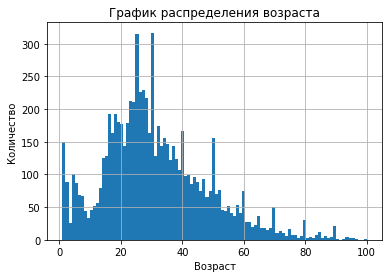

In [8]:
labels.hist(bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('График распределения возраста')
plt.show()

In [9]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


Похоже на нормальное распределение с небольшим перекосом. Основная часть данных по возрасту приходится на возраст от 20 до 40 лет

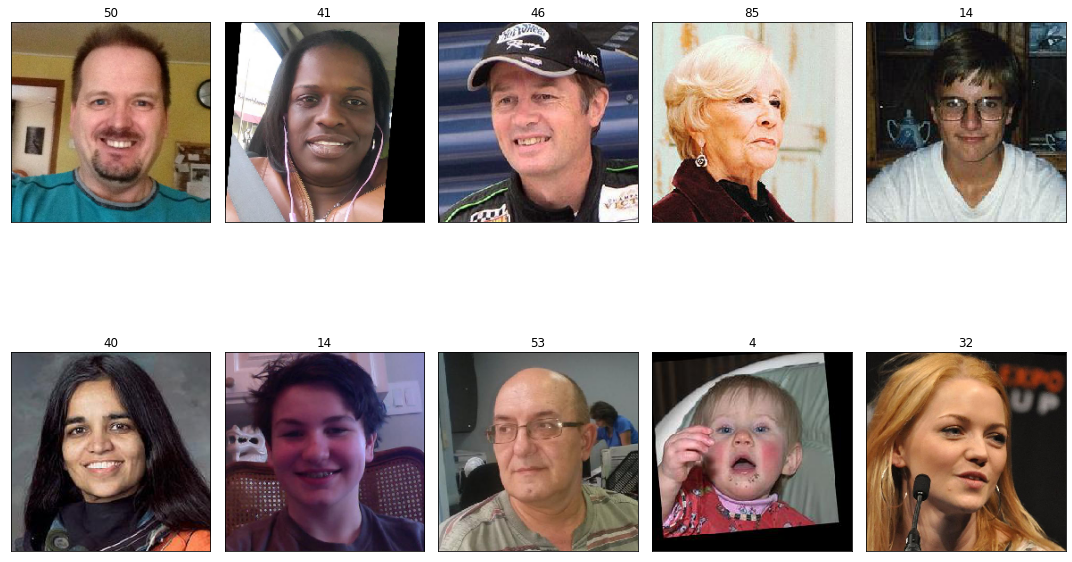

In [10]:
fig = plt.figure(figsize=(15,15))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

В данных есть различной четкости, освещенности и разного качества фото. С очками и бородой, которые закрывают часть лица. Это усложнит работу моделию. Посмотрим, что получится.

## Обучение модели

In [11]:
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1./255, horizontal_flip=True, validation_split=0.25)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')  
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae']) 
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

## Результаты

Epoch 1/10
178/178 - 51s - loss: 194.4938 - mae: 10.3964 - val_loss: 627.0410 - val_mae: 19.9552
Epoch 2/10
178/178 - 41s - loss: 108.1998 - mae: 7.8748 - val_loss: 659.9562 - val_mae: 20.6005
Epoch 3/10
178/178 - 41s - loss: 88.9522 - mae: 7.1247 - val_loss: 356.9222 - val_mae: 13.9926
Epoch 4/10
178/178 - 40s - loss: 70.9579 - mae: 6.3747 - val_loss: 261.4204 - val_mae: 11.8159
Epoch 5/10
178/178 - 38s - loss: 56.9703 - mae: 5.7768 - val_loss: 123.0376 - val_mae: 8.4364
Epoch 6/10
178/178 - 38s - loss: 47.7043 - mae: 5.2694 - val_loss: 77.1238 - val_mae: 6.5404
Epoch 7/10
178/178 - 38s - loss: 38.1405 - mae: 4.7417 - val_loss: 79.6338 - val_mae: 6.6350
Epoch 8/10
178/178 - 38s - loss: 32.2830 - mae: 4.3553 - val_loss: 83.4492 - val_mae: 6.8892
Epoch 9/10
178/178 - 38s - loss: 29.1023 - mae: 4.1168 - val_loss: 86.5165 - val_mae: 7.1629
Epoch 10/10
178/178 - 38s - loss: 25.6471 - mae: 3.8734 - val_loss: 97.8313 - val_mae: 7.1432

Наилучший результат MAE на тестовой выборке - 7.14 достигнут на 10 эпохе

## Вывод

В имеющемся датасете содержится 7591 фотографий размером 224х224. Перед моделью была поставлена задача регрессии по определению возраста по фотографии и чтобы МАЕ было около 7 и ниже.

Для обучения взяли предобученную нейронную сеть с архитектурой ResNet50 и дополнительно обучили ее на имеющихся данных. использовали оптимизатор Adam с шагом обучения 0.0005. В качестве функции потерь использовался Mean Squared Error, тк она подходит для задач регрессии.